**Objective of this notebook:**

In this notebook, we intend to explore the given dataset and make some inferences along the way. We will also build a baseline light gbm model to get started. 

**Objective of the competition:**

In this competition, the objective was to analyze the Google Merchandise Store (also known as GStore, where Google swag is sold) customer dataset to predict revenue per customer. 

In [4]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import model_selection, preprocessing, metrics
import lightgbm as lgb

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

In [5]:
#Trebali bismo imati 64-bitnu verziju pythona, jer 32-bitna koristi samo 4GB RAM-a
import platform, sys
platform.architecture(), sys.maxsize

(('64bit', 'WindowsPE'), 9223372036854775807)

**About the dataset:**

Similar to most other kaggle competitions, we are given two datasets
* train_v2.csv
* test_v2.csv

Each row in the dataset is one visit to the store. We are predicting the natural logarithm of the sum of all transactions per user. 

The train_v2.csv dataset has 1708337 instances (rows).\
The test_v2.csv dataset has 401589 instances (rows).
    
The data fields in the given files are 
* fullVisitorId - A unique identifier for each user of the Google Merchandise Store.
* channelGrouping - The channel via which the user came to the Store.
* date - The date on which the user visited the Store.
* device - The specifications for the device used to access the Store.
* geoNetwork - This section contains information about the geography of the user.
* socialEngagementType - Engagement type, either "Socially Engaged" or "Not Socially Engaged".
* totals - This section contains aggregate values across the session.
* trafficSource - This section contains information about the Traffic Source from which the session originated.
* visitId - An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user. For a completely unique ID, you should use a combination of fullVisitorId and visitId.
* visitNumber - The session number for this user. If this is the first session, then this is set to 1.
* visitStartTime - The timestamp (expressed as POSIX time).
* hits - This row and nested fields are populated for any and all types of hits. Provides a record of all page visits.
* customDimensions - This section contains any user-level or session-level custom dimensions that are set for a session. This is a repeated field and has an entry for each dimension that is set.

Also, it is important to note that 4 columns are in JSON format which could make data loading quite complicated.

After parsing the JSON columns and having a first glance at the data, we have decided to clean it as much as we can before performing the exploratory data analysis. Parsed data gave us a total of 60 columns. In the process of cleaning we have managed to eliminate 22 columns, 19 of which come from JSON columns.
* Column hits from the original list of columns was eliminated because it turned out that he has a duplicate column in the parsed version of JSON column totals.
* Column customDimensions from the original list of columns was eliminated because it is too complicated to parse and as such basically worthless.
* All the other columns were eliminated because they have constant values for all the rows in both datasets.




In [8]:
%%time
train_df = pd.read_csv('C:/Users/Ivan/Desktop/Machine learning/Projekt/train_v2_cleaned.csv', encoding='latin1', dtype={'fullVisitorId': 'str'})

Wall time: 6.75 s


In [9]:
train_df.shape

(1708337, 38)

In [10]:
train_df.head()

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,browser,operatingSystem,isMobile,deviceCategory,continent,subContinent,country,region,metro,city,networkDomain,campaign,source,medium,keyword,referralPath,isTrueDirect,adContent,adwordsClickInfo.page,adwordsClickInfo.slot,adwordsClickInfo.gclId,adwordsClickInfo.adNetworkType,adwordsClickInfo.isVideoAd,hits,pageviews,bounces,newVisits,sessionQualityDim,timeOnSite,transactions,transactionRevenue,totalTransactionRevenue
0,Organic Search,2017-10-16,3162355547410993243,1508198450,1,1508198450,Firefox,Windows,False,desktop,Europe,Western Europe,Germany,not available in demo dataset,not available in demo dataset,not available in demo dataset,(not set),(not set),google,organic,water bottle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN
1,Referral,2017-10-16,8934116514970143966,1508176307,6,1508176307,Chrome,Chrome OS,False,desktop,Americas,Northern America,United States,California,San Francisco-Oakland-San Jose CA,Cupertino,(not set),(not set),sites.google.com,referral,NaN,/a/google.com/transportation/mtv-services/bike...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2.0,NaN,NaN,2.0,28.0,NaN,NaN,NaN
2,Direct,2017-10-16,7992466427990357681,1508201613,1,1508201613,Chrome,Android,True,mobile,Americas,Northern America,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,windjammercable.net,(not set),(direct),(none),NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,2,2.0,NaN,1.0,1.0,38.0,NaN,NaN,NaN
3,Organic Search,2017-10-16,9075655783635761930,1508169851,1,1508169851,Chrome,Windows,False,desktop,Asia,Western Asia,Turkey,not available in demo dataset,not available in demo dataset,not available in demo dataset,unknown.unknown,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2.0,NaN,1.0,1.0,1.0,NaN,NaN,NaN
4,Organic Search,2017-10-16,6960673291025684308,1508190552,1,1508190552,Chrome,Windows,False,desktop,Americas,Central America,Mexico,not available in demo dataset,not available in demo dataset,not available in demo dataset,prod-infinitum.com.mx,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2.0,NaN,1.0,1.0,52.0,NaN,NaN,NaN


In [11]:
%%time
test_df = pd.read_csv('C:/Users/Ivan/Desktop/Machine learning/Projekt/test_v2_cleaned.csv', encoding='latin1', dtype={'fullVisitorId': 'str'})


Wall time: 1.52 s


In [12]:
test_df.shape

(401589, 38)

In [13]:
test_df.head()

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,browser,operatingSystem,isMobile,deviceCategory,continent,subContinent,country,region,metro,city,networkDomain,referralPath,campaign,source,medium,keyword,adContent,isTrueDirect,adwordsClickInfo.page,adwordsClickInfo.slot,adwordsClickInfo.gclId,adwordsClickInfo.adNetworkType,adwordsClickInfo.isVideoAd,hits,pageviews,timeOnSite,sessionQualityDim,newVisits,transactions,transactionRevenue,totalTransactionRevenue,bounces
0,Organic Search,2018-05-11,7460955084541987166,1526099341,2,1526099341,Chrome,Android,True,mobile,Asia,Southern Asia,India,Delhi,(not set),(not set),unknown.unknown,(not set),(not set),google,organic,(not provided),(not set),True,NaN,NaN,NaN,NaN,NaN,4,3.0,973.0,1,NaN,NaN,NaN,NaN,NaN
1,Direct,2018-05-11,460252456180441002,1526064483,166,1526064483,Chrome,Macintosh,False,desktop,Americas,Northern America,United States,California,San Francisco-Oakland-San Jose CA,San Francisco,(not set),(not set),(not set),(direct),(none),(not set),(not set),True,NaN,NaN,NaN,NaN,NaN,4,3.0,49.0,1,NaN,NaN,NaN,NaN,NaN
2,Organic Search,2018-05-11,3461808543879602873,1526067157,2,1526067157,Chrome,Chrome OS,False,desktop,Americas,Northern America,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,onlinecomputerworks.com,(not set),(not set),google,organic,(not provided),(not set),True,NaN,NaN,NaN,NaN,NaN,4,3.0,24.0,1,NaN,NaN,NaN,NaN,NaN
3,Direct,2018-05-11,975129477712150630,1526107551,4,1526107551,Chrome,iOS,True,mobile,Americas,Northern America,United States,Texas,Houston TX,Houston,(not set),(not set),(not set),(direct),(none),(not set),(not set),True,NaN,NaN,NaN,NaN,NaN,5,4.0,25.0,1,NaN,NaN,NaN,NaN,NaN
4,Organic Search,2018-05-11,8381672768065729990,1526060254,1,1526060254,Internet Explorer,Windows,True,tablet,Americas,Northern America,United States,California,Los Angeles CA,Irvine,com,(not set),(not set),google,organic,(not provided),(not set),NaN,NaN,NaN,NaN,NaN,NaN,5,4.0,49.0,1,1.0,NaN,NaN,NaN,NaN


**Target Variable Exploration:**

Since we are predicting the natural logarithm of the sum of all transactions per unique user, let's add the total transaction revenue for each user and perform the log function.
Then, we will draw a scatter plot.

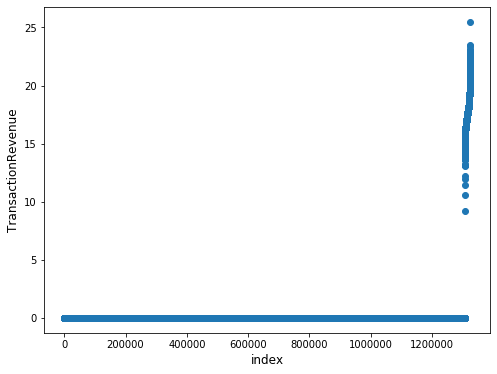

In [14]:
train_df["transactionRevenue"] = train_df["transactionRevenue"].astype('float')
gdf = train_df.groupby("fullVisitorId")["transactionRevenue"].sum().reset_index()
#grupirali smo po svakom jedinstvenom fullVisitorId
#tako da smo za svakog jedinstvenog full Visitor Id zbrojili njegov transaction Revenue iz svakog njegovog posjeta
#na taj nacin smo dobili ukupan zbroj svih transakcija po korisniku

#sortirali smo to od najmanjih potrosaca, prema najvecima i nacrtali
plt.figure(figsize=(8,6))
plt.scatter(range(gdf.shape[0]), np.sort(np.log1p(gdf["transactionRevenue"].values)))
plt.xlabel('index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.show()

As we can see, this plot confirms the first two lines of the competition overview:

    "The 80/20 rule has proven true for many businesses–only a small percentage of customers produce most of the revenue. As such, marketing teams are challenged to make appropriate investments in promotional strategies."

Infact in this case, the ratio is even less.     

In [15]:
nzi = pd.notnull(train_df["transactionRevenue"]).sum()
nzr = (gdf["transactionRevenue"]>0).sum()
print("Number of instances in the train set with non-zero revenue : ", nzi, " and the ratio is : ", nzi / train_df.shape[0])
print("Number of unique customers with non-zero revenue : ", nzr, "and the ratio is : ", nzr / gdf.shape[0])

Number of instances in the train set with non-zero revenue :  18514  and the ratio is :  0.010837440153786987
Number of unique customers with non-zero revenue :  16141 and the ratio is :  0.012193574218307359


So, the ratio of revenue generating customers to customers with no revenue in a reduced train set is in the ratio of 1.21%

Since most of the rows have zero revenues, in the following plots let's have a look at the count of each category of the variable along with the number of instances where the revenue is not zero.

**Number of visitors and common visitors:**

Let's look at the number of unique visitors in the reduced train and the reduced test set along with teir respective percentages and also print out the number of common visitors.

In [16]:
#ovdje su brojevi jedinstvenih fullVisitorId u smanjenom train i test setu
#ovdje je i kolicina jedinstvenih fullVisitorId koji se nalaze i u smanjenom train setu i u smanjenom test setu (846)
print("Number of unique visitors in the train set : ",train_df.fullVisitorId.nunique(), " out of rows : ",train_df.shape[0])
print("Number of unique visitors in the test set : ",test_df.fullVisitorId.nunique(), " out of rows : ",test_df.shape[0])
print("Number of common visitors in the train and the test set : ",len(set(train_df.fullVisitorId.unique()).intersection(set(test_df.fullVisitorId.unique())) ))
print("Percentage of unique visitors in the train set : ", train_df.fullVisitorId.nunique()/train_df.shape[0])
print("Percentage of unique visitors in the test set : ", test_df.fullVisitorId.nunique()/test_df.shape[0] )

Number of unique visitors in the train set :  1323730  out of rows :  1708337
Number of unique visitors in the test set :  296530  out of rows :  401589
Number of common visitors in the train and the test set :  2759
Percentage of unique visitors in the train set :  0.774864678339227
Percentage of unique visitors in the test set :  0.7383917388175473


**Columns with constant values:**

As we have successfully cleaned our data, there is no more columns with constant values. 

In [18]:
%%time
const_cols = [c for c in train_df.columns if train_df[c].nunique(dropna=False)==1 ]
const_cols

Wall time: 2.38 s


[]

**Device Information:**

Here we look at the distributions of Device Browser (Chrome, Firefox...), Device category(Desktop, mobile...) and Device OS (Windows, Android...). That is, of course, regarding to the device used to visit Google Store.

In [19]:
def horizontal_bar_chart(cnt_srs, color):
    trace = go.Bar(
        y=cnt_srs.index[::-1],
        x=cnt_srs.values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

# Device Browser
cnt_srs = train_df.groupby('browser')['transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(50, 171, 96, 0.6)')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'rgba(50, 171, 96, 0.6)')
trace3 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'rgba(50, 171, 96, 0.6)')

# Device Category
cnt_srs = train_df.groupby('deviceCategory')['transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace4 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(71, 58, 131, 0.8)')
trace5 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'rgba(71, 58, 131, 0.8)')
trace6 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'rgba(71, 58, 131, 0.8)')

# Operating system
cnt_srs = train_df.groupby('operatingSystem')['transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace7 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(246, 78, 139, 0.6)')
trace8 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10),'rgba(246, 78, 139, 0.6)')
trace9 = horizontal_bar_chart(cnt_srs["mean"].head(10),'rgba(246, 78, 139, 0.6)')

# Creating two subplots
fig = tools.make_subplots(rows=3, cols=3, vertical_spacing=0.04, 
                          subplot_titles=["Device Browser - Count", "Device Browser - Non-zero Revenue Count", "Device Browser - Mean Revenue",
                                          "Device Category - Count",  "Device Category - Non-zero Revenue Count", "Device Category - Mean Revenue", 
                                          "Device OS - Count", "Device OS - Non-zero Revenue Count", "Device OS - Mean Revenue"])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)
fig.append_trace(trace7, 3, 1)
fig.append_trace(trace8, 3, 2)
fig.append_trace(trace9, 3, 3)

fig['layout'].update(height=1200, width=1200, paper_bgcolor='rgb(233,233,233)', title="Device Plots")
py.iplot(fig, filename='device-plots')

C:\ProgramData\Anaconda3\lib\site-packages\plotly\tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



Inferences:
* Device browser distribution looks similar on both the general count and the count of non-zero revenue plots, except for a possibly smaller percentage of Safari users in the non-zero revenue plot.
* On the device category front, Desktop seems to have higher percentage of non-zero revenue counts compared to mobile devices.
* As for the Device operating system distribution, although the general number of counts is bigger for Windows, the number of counts where revenue is not zero is more for Macintosh. This could suggest that Macintosh users will spend more.
* Chrome OS also has a bit higher percentage of non-zero revenue counts.
* On the mobile OS side, looks like Android users are visiting the most, but the iOS users are producing more frequent non-zero revenue.

**Date Exploration:**

In [20]:
import datetime

def scatter_plot(cnt_srs, color):
    trace = go.Scatter(
        x=cnt_srs.index[::-1],
        y=cnt_srs.values[::-1],
        showlegend=False,
        marker=dict(
            color=color,
        ),
    )
    return trace

train_df['date'] = train_df['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))
cnt_srs = train_df.groupby('date')['totals.transactionRevenue'].agg(['size', 'count'])
cnt_srs.columns = ["count", "count of non-zero revenue"]
cnt_srs = cnt_srs.sort_index()
#cnt_srs.index = cnt_srs.index.astype('str')
trace1 = scatter_plot(cnt_srs["count"], 'red')
trace2 = scatter_plot(cnt_srs["count of non-zero revenue"], 'blue')

fig = tools.make_subplots(rows=2, cols=1, vertical_spacing=0.08,
                          subplot_titles=["Date - Count", "Date - Non-zero Revenue count"])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 2, 1)
fig['layout'].update(height=800, width=800, paper_bgcolor='rgb(233,233,233)', title="Date Plots")
py.iplot(fig, filename='date-plots')

ValueError: invalid literal for int() with base 10: '0-16'

Inferences: **POPRAVITI OVO**
* We have data from 1 Aug, 2016 to 30 April, 2018 in our training dataset.
* These plots suggest that the number of visitors could be increasing in the dates before Christmas.

In [21]:
test_df['date'] = test_df['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))
cnt_srs = test_df.groupby('date')['fullVisitorId'].size()


trace = scatter_plot(cnt_srs, 'red')

layout = go.Layout(
    height=400,
    width=800,
    paper_bgcolor='rgb(233,233,233)',
    title='Dates in Test set'
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="ActivationDate")

ValueError: invalid literal for int() with base 10: '5-11'

* In our test dataset we have dates from 1 May, 2018 to 15 Oct, 2018.
* There are no common dates between train and test set. It might be a good idea to do time based validation for this dataset.

**Geographic Information:**

In [22]:
# Continent
cnt_srs = train_df.groupby('continent')['transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(58, 71, 80, 0.6)')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'rgba(58, 71, 80, 0.6)')
trace3 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'rgba(58, 71, 80, 0.6)')

# Sub-continent
cnt_srs = train_df.groupby('subContinent')['transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace4 = horizontal_bar_chart(cnt_srs["count"], 'orange')
trace5 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"], 'orange')
trace6 = horizontal_bar_chart(cnt_srs["mean"], 'orange')

# Network domain
cnt_srs = train_df.groupby('networkDomain')['transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace7 = horizontal_bar_chart(cnt_srs["count"].head(10), 'blue')
trace8 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'blue')
trace9 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'blue')

# Creating two subplots
fig = tools.make_subplots(rows=3, cols=3, vertical_spacing=0.08, horizontal_spacing=0.15, 
                          subplot_titles=["Continent - Count", "Continent - Non-zero Revenue Count", "Continent - Mean Revenue",
                                          "Sub Continent - Count",  "Sub Continent - Non-zero Revenue Count", "Sub Continent - Mean Revenue",
                                          "Network Domain - Count", "Network Domain - Non-zero Revenue Count", "Network Domain - Mean Revenue"])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)
fig.append_trace(trace7, 3, 1)
fig.append_trace(trace8, 3, 2)
fig.append_trace(trace9, 3, 3)

fig['layout'].update(height=1500, width=1200, paper_bgcolor='rgb(233,233,233)', title="Geography Plots")
py.iplot(fig, filename='geo-plots')

Inferences:
* On the continent plot, we can see that America has both higher number of general counts, as well as the highest number of counts where the revenue is non-zero. In fact, it looks like America is producing almost all non-zero revenue counts.
* Though Asia and Europe have a high number of counts, the number of non-zero revenue counts from these continents are comparatively low. 
* The first two points are also evident in the sub-continents plot where we can deduce that it is predominantly North America that is contributing to all of this.
* If the network domain is "unknown.unknown" rather than "(not set)", then the number of counts with non-zero revenue tend to be lower. 

**Traffic Source:**


In [23]:
# Continent
cnt_srs = train_df.groupby('source')['transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(10), 'green')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'green')
trace3 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'green')

# Sub-continent
cnt_srs = train_df.groupby('medium')['transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace4 = horizontal_bar_chart(cnt_srs["count"], 'purple')
trace5 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"], 'purple')
trace6 = horizontal_bar_chart(cnt_srs["mean"], 'purple')

# Creating two subplots
fig = tools.make_subplots(rows=2, cols=3, vertical_spacing=0.08, horizontal_spacing=0.15, 
                          subplot_titles=["Traffic Source - Count", "Traffic Source - Non-zero Revenue Count", "Traffic Source - Mean Revenue",
                                          "Traffic Source Medium - Count",  "Traffic Source Medium - Non-zero Revenue Count", "Traffic Source Medium - Mean Revenue"
                                          ])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)

fig['layout'].update(height=1000, width=1200, paper_bgcolor='rgb(233,233,233)', title="Traffic Source Plots")
py.iplot(fig, filename='traffic-source-plots')

Inferences:
* In the traffic source plot, though Youtube has high number of general counts in the dataset, the number of non-zero revenue counts for Youtube is very small. 

* On the traffic source medium, "referral" has less non-zero revenue count compared to "organic" medium.

**Visitor Profile:**

Now let's have a look at the visitor profile variables like number of pageviews by the visitor and number of hits by the visitor.

In [24]:

# Page views
cnt_srs = train_df.groupby('pageviews')['transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(60), 'cyan')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(60), 'cyan')
trace5 = horizontal_bar_chart(cnt_srs["mean"].head(60), 'cyan')

# Hits
cnt_srs = train_df.groupby('hits')['transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", 'mean']
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace3 = horizontal_bar_chart(cnt_srs["count"].head(60), 'black')
trace4 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(60), 'black')
trace6 = horizontal_bar_chart(cnt_srs["mean"].head(60), 'black')

# Creating two subplots
fig = tools.make_subplots(rows=2, cols=3, vertical_spacing=0.08, horizontal_spacing=0.15, 
                          subplot_titles=["Total Pageviews - Count", "Total Pageviews - Non-zero Revenue Count", "Total Pageviews - Mean Revenue",
                                          "Total Hits - Count",  "Total Hits - Non-zero Revenue Count", "Total Hits - Mean Revenue"])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace5, 1, 3)
fig.append_trace(trace3, 2, 1)
fig.append_trace(trace4, 2, 2)
fig.append_trace(trace6, 2, 3)

fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Visitor Profile Plots")
py.iplot(fig, filename='visitor-profile-plots')

**Inferences**
* Both these variables look very predictive and could prove to be extremely useful.
* The general count plots show a decreasing nature i.e. we have a very high general count for less number of hits and page views per visitor transaction (1 or 2 hits) and the overall count decreases when the number of hits and page views per visitor transaction increases.
* On the other hand, we can clearly see that when the number of hits / pageviews per visitor transaction increases, that there is a high number of non-zero revenue counts. 
